In [141]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA

## Redução de dimensionalidade
##### utilizando PCA

In [142]:

#função para aplicar PCA e plotar os pontos no 2D, sendo os eixos os dois componentes principais
def apply_and_plot_pca(df, class_column, labels):

    #filtrar o DataFrame para conter apenas as linhas com labels das duas classes desejadas
    df = df[df[class_column].isin([labels[0], labels[1]])]
    
    #armazenar os labels e remover a coluna de labels do DataFrame, para que não seja incluída no PCA
    labels_column = df[class_column]
    df = df.drop(columns=[class_column])

    #aplicar PCA
    pca = PCA(n_components=2)
    components = pca.fit_transform(df)

    #criar um novo DataFrame só com os dois componentes principais
    pca_df = pd.DataFrame(components, columns=['x', 'y'])
    pca_df[class_column] = labels_column.values

    #mapear os pontos de cada classe para uma cor diferente
    colors = {labels[0]: 'red', labels[1]: 'blue'}
    label_colors = labels_column.map(colors)

    #plotar o gráfico de dispersão
    plt.scatter(pca_df['x'], pca_df['y'], c=label_colors)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of Dataset')

    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label=labels[0]),
                        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label=labels[1])],
               loc='upper right')
    plt.show()

    
    return pca_df



## exemplos de datsets ja testados


* ### a string **class_column** deve ser ajustada para cada dataset, com o nome da coluna que contem a classificação;

* ### o array **labels** deve ser ajustado para cada dataset, com os nomes das duas classes;

* ### o primeiro parametro de **apply_and_plot_pca** devem ser ajustados para cada dataset, com seu nome;




## IMPORTANDO O DATASET 
* #### DEFININDO A COLUNA DE CLASSIFICAÇÃO E OS LABELS
* ####  APLICANDO O PCA E PLOTANDO O GRAFICO

### MUDAR O CÓDIGO SOMENTE AQUI!!!!!!!!!!!!

In [144]:
# Exemplo de uso com o dataset Iris
from sklearn.datasets import load_iris
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target_names[iris.target]
iris_df.head()

#MUDAR AQUI!!!!!!!!!!!
class_column = 'species'
labels = ['setosa', 'versicolor']


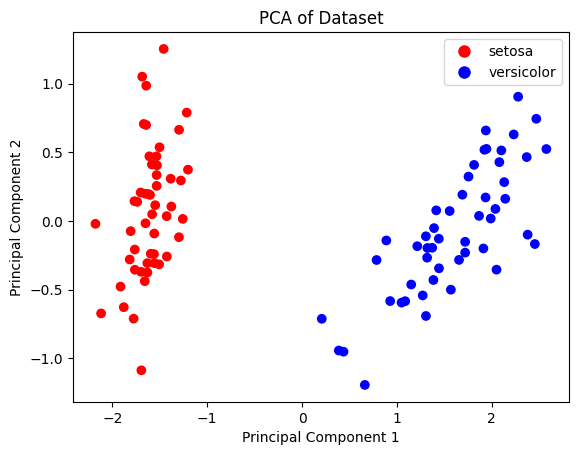

In [145]:

pca_df = apply_and_plot_pca(iris_df, class_column, labels)

### SEPARANDO O DATASET EM TREINO E TESTE

In [146]:
from sklearn.model_selection import train_test_split

# Dividindo o DataFrame em treino e teste
train_df, test_df = train_test_split(pca_df, test_size=0.3, random_state=30)

# Verificando os tamanhos dos conjuntos
print("Tamanho do conjunto de treino:", len(train_df))
print("Tamanho do conjunto de teste:", len(test_df))

print(train_df.head())





Tamanho do conjunto de treino: 70
Tamanho do conjunto de teste: 30
           x         y     species
95  1.392548 -0.051616  versicolor
32 -1.670216  0.706417      setosa
63  2.040115  0.087959  versicolor
69  1.151803 -0.462055  versicolor
29 -1.557562 -0.306426      setosa


In [147]:
print(test_df.head())

           x         y     species
20 -1.278599  0.295007      setosa
91  1.936080  0.171507  versicolor
34 -1.562699 -0.240627      setosa
52  2.471603  0.743956  versicolor
8  -1.777007 -0.710388      setosa


# Envoltória Convexa
Computação da Envolória Convexa utilizando a Varredura de Graham

In [148]:
#função para calcular posição relativa entre pontos
def orientation(p, q, r):
    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
    if val == 0: return 0  # colinear
    return 1 if val > 0 else 2  # horário (1) ou anti-horário (2)

#função para calcular ângulo polar entre dois pontos
def polar_angle(p0, p1):
    y_span = p1[1] - p0[1]
    x_span = p1[0] - p0[0]
    return np.arctan2(y_span, x_span)

#função para calcular distância entre dois pontos
def distance(p0, p1):
    return (p1[0] - p0[0])**2 + (p1[1] - p0[1])**2

#função para calcular a envoltória convexa de um conjunto de pontos
def graham_scan(points):
    n = len(points)

    #ponto com a coordenada y mais baixa
    ymin = min(points, key=lambda x: x[1])
    min_index = points.index(ymin)
    points[0], points[min_index] = points[min_index], points[0]  #troca o ponto inicial com o primeiro ponto

    #ordena os pontos por ângulo polar e depois por distância
    pivot = points[0]
    sorted_points = sorted(points[1:], key=lambda x: (polar_angle(pivot, x), -distance(pivot, x))) #ordena por ângulo polar e depois por distância em caso de empate

    #inicializa a pilha de pontos
    stack = [pivot, sorted_points[0], sorted_points[1]]

    #processamento
    for point in sorted_points[2:]:
        #enquanto houver mudança de direção no sentido horário, remove o último ponto da pilha
        while len(stack) > 1 and orientation(stack[-2], stack[-1], point) !=2:
            stack.pop()
        stack.append(point)
    
    return stack


# Interseção 
##### checar se as classes são linearmente separáveis, para assim poder gerar um hiperplano que as separe e classifique corretamente

In [149]:
#função para verificar se dois segmentos se interceptam
def doIntersect(p1, q1, p2, q2):
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    if o1 != o2 and o3 != o4:
        return True

    return False

#função para dividir os pontos do dataset entre as duas classes
def divide_points(pca_df, class_column, labels):

    #separar os pontos de cada classe em arrays
    class1_points = pca_df[pca_df[class_column] == labels[0]][['x', 'y']].values
    class2_points = pca_df[pca_df[class_column] == labels[1]][['x', 'y']].values

    #calcular a envoltória convexa de cada classe
    hull_class1 = graham_scan(class1_points.tolist())
    hull_class2 = graham_scan(class2_points.tolist())

    return class1_points, class2_points, hull_class1, hull_class2


#função para verificar se as classes são separáveis linearmente
def check_separability(hull_class1, hull_class2):

    are_separable = True

    for i in range(len(hull_class1) - 1): #iterar sobre os pontos da envoltória convexa da classe 1

        for j in range(len(hull_class2) - 1): #iterar sobre os pontos da envoltória convexa da classe 2

            #verificar se os segmentos formados pelo ponto atual e o próximo (de cada classe) se interceptam
            if doIntersect(hull_class1[i], hull_class1[i + 1], hull_class2[j], hull_class2[j + 1]): 
                are_separable = False
                break

    #imprimir o resultado
    if are_separable:
        print("As classes são separáveis linearmente.")
    else:
        print("As classes não são separáveis linearmente.")
        



In [150]:
# Função para verificar a separabilidade linear usando a linha de varredura
def check_separability_linear_scan(hull1, hull2):
    events = []
    
    # Adiciona eventos para a primeira envoltória
    for i in range(len(hull1) - 1):
        p1, p2 = sorted([hull1[i], hull1[i + 1]])  # ordena os pontos para garantir consistência
        events.append((p1, 'start', (p1, p2), 'hull1'))
        events.append((p2, 'end', (p1, p2), 'hull1'))

    # Adiciona eventos para a segunda envoltória
    for i in range(len(hull2) - 1):
        p1, p2 = sorted([hull2[i], hull2[i + 1]])  # ordena os pontos para garantir consistência
        events.append((p1, 'start', (p1, p2), 'hull2'))
        events.append((p2, 'end', (p1, p2), 'hull2'))
    
    # Ordena os eventos pela coordenada x
    events.sort(key=lambda x: x[0][0])

    active_segments = []

    for event in events:
        _, event_type, segment, hull_type = event

        if event_type == 'start':
            # Ao encontrar um evento de início, verifica se o segmento intersecta com algum segmento ativo de outra envoltória
            for active_segment in active_segments:
                if doIntersect(*segment, *active_segment[0]) and hull_type != active_segment[1]:
                    return False  # se houver interseção, as envoltórias não são separáveis

            active_segments.append((segment, hull_type))  # adiciona o segmento à lista de segmentos ativos

        else:
            active_segments.remove((segment, hull_type))  # ao encontrar um evento de fim, remove o segmento da lista de ativos

    return True  # se não encontrou interseções, as envoltórias são separáveis

In [151]:

class1_points, class2_points, hull_class1, hull_class2 = divide_points(train_df, class_column, labels)
check_separability(hull_class1, hull_class2)


As classes são separáveis linearmente.


In [152]:

class1_points, class2_points, hull_class1, hull_class2 = divide_points(train_df, class_column, labels)
check_separability_linear_scan(hull_class1, hull_class2)


True

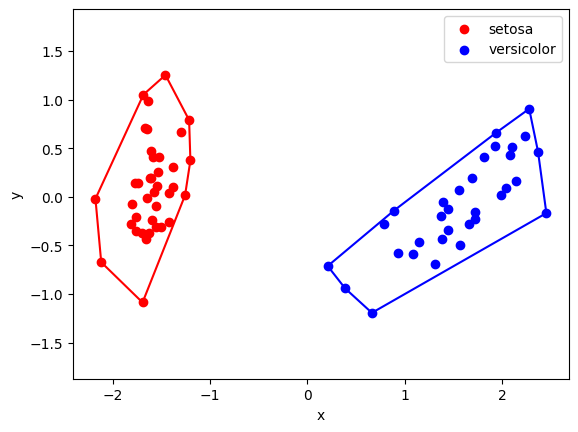

In [153]:
#plot envoltórias convexas
def plot_hulls(hull_class1, hull_class2, class1_points, class2_points, labels):
    plt.scatter(class1_points[:, 0], class1_points[:, 1], c='r', label=labels[0])
    plt.scatter(class2_points[:, 0], class2_points[:, 1], c='b', label=labels[1])

    hull_class1 = np.vstack((hull_class1, hull_class1[0]))
    hull_class2 = np.vstack((hull_class2, hull_class2[0]))

    plt.plot(hull_class1[:, 0], hull_class1[:, 1], 'r-')
    plt.plot(hull_class2[:, 0], hull_class2[:, 1], 'b-')


    plt.xlabel(pca_df.columns[0])
    plt.ylabel(pca_df.columns[1])
    plt.legend()
    plt.axis('equal')



plot_hulls(hull_class1, hull_class2, class1_points, class2_points, labels)


# Ponto mais próximo

Calcular o ponto de uma envoltória mais próximo de outra envoltória e em seguida plotar o segmento de reta entre os dois pontos

In [154]:

#função para calcular a distância euclidiana entre dois pontos
def euclidean_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

#função para calcular a distância de um ponto até um segmento de reta
def point_to_segment_distance(p, a, b):

    #vetorizando os pontos
    p = np.array(p)
    a = np.array(a)
    b = np.array(b)
    
    #calculando os vetores
    ap = p - a
    ab = b - a
    
    #calculando o produto escalar
    dot_product = np.dot(ap, ab) / np.dot(ab, ab)
    
    #evitando que o ponto de projeção saia do segmento de linha
    dot_product = np.clip(dot_product, 0, 1)
    
    #calculando o ponto de projeção no segmento de linha
    projection = a + dot_product * ab
    
    #retornando a distancia euclidiana entre o ponto e a projeção dele no segmento
    return euclidean_distance(p, projection), projection


def plot_hulls_and_seg(hull_class1, hull_class2, closest_pair, class1_points, class2_points, labels):
    
    plot_hulls(hull_class1, hull_class2, class1_points, class2_points, labels)

    # Plotar a menor distância
    plt.plot(*closest_pair[0], 'go')  # ponto ou projeção na envoltória 1
    plt.plot(*closest_pair[1], 'go')  # ponto ou projeção na envoltória 2
    plt.plot([closest_pair[0][0], closest_pair[1][0]], 
            [closest_pair[0][1], closest_pair[1][1]], 'g-')  # linha representando a menor distância
    
    

#função para calcular o par de pontos mais próximos entre as duas classes, que geram o menor segmento entre as duas envoltórias convexas
def min_hulls_distance(hull_class1, hull_class2):
    
    min_distance = float('inf') #menor distância entre as envoltórias convexas, inicializada com infinito
    closest_pair = (None, None) #par de pontos mais próximos entre as duas envoltórias convexas, inicializados com None

    #distância entre pontos de cada classe
    for p1 in hull_class1:
        for p2 in hull_class2:
            distance = euclidean_distance(p1, p2)
            if distance < min_distance:
                min_distance = distance
                closest_pair = (p1, p2)

    #distância entre a projecao de cada ponto de uma classe no segmento formado por dois pontos da outra classe
    for i in range(len(hull_class1) - 1): #projecao dos pontos da classe 2 no segmento formado por dois pontos da classe 1
        for p2 in hull_class2:
            distance, projection = point_to_segment_distance(p2, hull_class1[i], hull_class1[i+1])
            if distance < min_distance:
                min_distance = distance
                closest_pair = (projection, p2)

    for i in range(len(hull_class2) - 1): #projecao dos pontos da classe 1 no segmento formado por dois pontos da classe 2
        for p1 in hull_class1:
            distance, projection = point_to_segment_distance(p1, hull_class2[i], hull_class2[i+1])
            if distance < min_distance:
                min_distance = distance
                closest_pair = (p1, projection)

    #ao final destes loops, o par de pontos mais próximos entre as duas envoltórias convexas estará armazenado na variável closest_pair

    return closest_pair


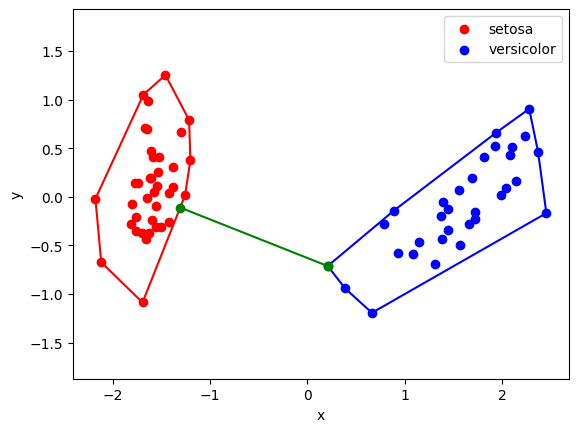

In [155]:
closest_pair = min_hulls_distance(hull_class1, hull_class2)

plot_hulls_and_seg(hull_class1, hull_class2, closest_pair, class1_points, class2_points, labels)

# Linha perpendicular de separação

In [156]:
#função para calcular a reta perpendicular ao segmento formado pelos dois pontos mais próximos entre as duas envoltórias convexas
def compute_perpendicular_line(p1, p2):

    #calcular a inclinação da reta que passa pelos dois pontos
    if p2[0] - p1[0] != 0:
        slope = (p2[1] - p1[1]) / (p2[0] - p1[0])

        #calcular a inclinação da reta perpendicular
        if slope != 0:
            perp_slope = -1 / slope
        else:
            perp_slope = 0 #reta horizontal
    else:
        perp_slope = float('inf') #reta vertical

    #calcular o ponto médio do segmento
    midpoint = [(p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2]

    #calcular o coeficiente linear da reta perpendicular
    y_intercept = midpoint[1] - perp_slope * midpoint[0]

    

    #retornar a inclinação, o coeficiente linear e o ponto médio da reta perpendicular
    return perp_slope, y_intercept, midpoint

#função para plotar a reta perpendicular ao segmento formado pelos dois pontos mais próximos entre as duas envoltórias convexas
def plot_hulls_and_seg_and_line(hull_class1, hull_class2, closest_pair, perp_slope, y_intercept, midpoint, class1_points, class2_points, labels, margin):

    plot_hulls_and_seg(hull_class1, hull_class2, closest_pair, class1_points, class2_points, labels)

     

    #ajustar o tamanho da reta perpendicular para que ela seja visível no gráfico
    if abs(perp_slope) != float('inf'):
        x = np.linspace(midpoint[0] - margin, midpoint[0] + margin, 400)
        y = perp_slope * x + y_intercept
        plt.plot(x, y, 'm-')
    else:
        plt.axvline(x=midpoint[0], color='m', linestyle='-')

    #setar os limites do gráfico para que a reta perpendicular seja o foco
    plt.xlim(midpoint[0] - margin, midpoint[0] + margin)
    plt.ylim(midpoint[1] - margin, midpoint[1] + margin)

    plt.axis('equal')

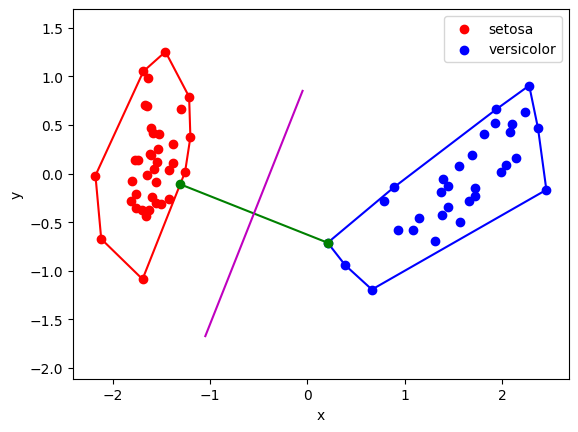

In [157]:
perp_slope, y_intercept, midpoint = compute_perpendicular_line(closest_pair[0], closest_pair[1])

plot_hulls_and_seg_and_line(hull_class1, hull_class2, closest_pair, perp_slope, y_intercept, midpoint, class1_points, class2_points, labels, 0.5)

## Verificar à qual classe um novo ponto pertence

In [158]:
#função para calcular a equação da reta perpendicular que passa pelo ponto médio
def perpendicular_line_equation(closest_pair):
    
    perp_slope, y_intercept, midpoint = compute_perpendicular_line(closest_pair[0], closest_pair[1])

    A = -perp_slope
    B = 1
    C = perp_slope * midpoint[0] - midpoint[1]

    line_coeficients = [A, B, C]
    return line_coeficients
    

def class_position(labels, closest_pair, line_coeficients):

    A, B, C = line_coeficients

    value = A * closest_pair[0][0] + B * closest_pair[0][1] + C
    if value > 0:
        class_above = labels[0]
        class_below = labels[1]
        return class_above, class_below
    elif value < 0:
        class_above = labels[1]
        class_below = labels[0]
        return class_above, class_below


def determine_class(class_above, class_below, point, line_coeficients):

    if len(line_coeficients) != 3:
        raise ValueError(f"Expected 3 coefficients, but got {len(line_coeficients)}: {line_coeficients}")
    A, B, C = line_coeficients

    #Determina a qual classe o ponto pertence

    value = A * point[0] + B * point[1] + C
    
    if value > 0:
        return class_above
    elif value < 0:
        return class_below
    else:
        return None
   


def plot_data( hull_class1, hull_class2, closest_pair, test_point, perp_slope, y_intercept, midpoint, class1_points, class2_points, labels, margin):
    
    plot_hulls_and_seg_and_line(hull_class1, hull_class2, closest_pair, perp_slope, y_intercept, midpoint, class1_points, class2_points, labels, margin)

    plt.plot(test_point[0], test_point[1], 'o', color='magenta', label='Test Point')

   
    plt.legend()
    plt.axis('equal')
    plt.show()



The test point belongs to the class: versicolor


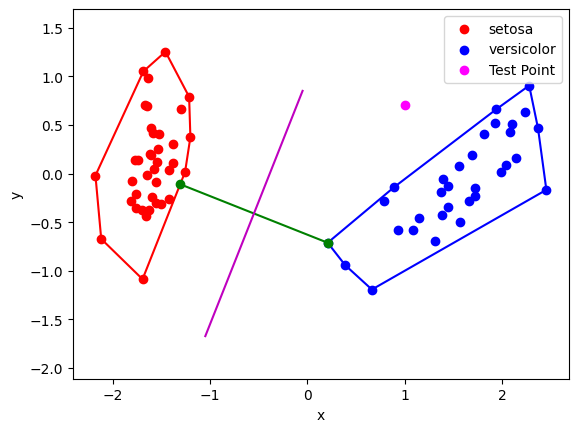

In [159]:
# Exemplo de uso:
line_coeficients = perpendicular_line_equation(closest_pair)
test_point = [1, 0.7]
class_above, class_below = class_position(labels, closest_pair, line_coeficients)
predicted_class = determine_class(class_above, class_below, test_point, line_coeficients)
print(f"The test point belongs to the class: {predicted_class}")
plot_data( hull_class1, hull_class2, closest_pair, test_point, perp_slope, y_intercept, midpoint, class1_points, class2_points, labels, 0.5)



### PREDIÇÃO DE CLASSE NO TESTSET

In [160]:
line_coeficients = perpendicular_line_equation(closest_pair)
class_above, class_below = class_position(labels, closest_pair, line_coeficients)

#função para prever as classes de um conjunto de pontos, baseando na sua posição em relação à reta perpendicular
def predict_classes(df, line_coeficients, class_above, class_below):

   #Aplica a função determine_class para cada ponto do dataset e armazena o resultado na coluna 'Predicted Class'
   df['Predicted Class'] = df.apply(lambda row: determine_class(class_above, class_below, [row['x'], row['y']], line_coeficients), axis=1)

   print(df.head())
   return df

predicted_df = predict_classes(test_df, line_coeficients, class_above, class_below)

predicted_df.head()


           x         y     species Predicted Class
20 -1.278599  0.295007      setosa          setosa
91  1.936080  0.171507  versicolor      versicolor
34 -1.562699 -0.240627      setosa          setosa
52  2.471603  0.743956  versicolor      versicolor
8  -1.777007 -0.710388      setosa          setosa


,x,y,species,Predicted Class
20,-1.278599,0.295007,setosa,setosa
91,1.936080,0.171507,versicolor,versicolor
34,-1.562699,-0.240627,setosa,setosa
52,2.471603,0.743956,versicolor,versicolor
8,-1.777007,-0.710388,setosa,setosa


### MÉTRICAS

In [161]:
from sklearn.metrics import precision_score, recall_score, f1_score

def metrics(predicted_df, class_column):
    # Obter os valores verdadeiros e os valores previstos
    y_true = predicted_df[class_column].values
    y_pred = predicted_df['Predicted Class'].values

    # Calcular precisão, recall e F1-score
    precision = precision_score(y_true, y_pred, average='macro')  # 'macro' considera cada classe igualmente importante
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print("Model Metrics:")
    print()
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print()
    print("-" * 30)
    

    precision_per_class = precision_score(y_true, y_pred, average=None)
    recall_per_class = recall_score(y_true, y_pred, average=None)
    f1_per_class = f1_score(y_true, y_pred, average=None)

    # Obter os rótulos únicos
    unique_labels = labels

    # Imprimir as métricas para cada classe
    for label, p, r, f1 in zip(unique_labels, precision_per_class, recall_per_class, f1_per_class):
        print()
        print(f"Metrics of Class: {label}")
        print()
        print(f"Precision: {p:.4f}")
        print(f"Recall: {r:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print()
        print("-" * 30)

In [162]:
metrics(predicted_df, class_column)

Model Metrics:

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------

Metrics of Class: setosa

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------

Metrics of Class: versicolor

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------


# Função para avaliar separação linear e classificar ponto de teste

In [163]:
def test_dataset(class_column, labels, df, margin):

    print("Classes:", labels)

    #verificando se há pontos suficientes para calcular a envoltória convexa em cada label
    if len(df[df[class_column] == labels[0]]) < 3 or len(df[df[class_column] == labels[1]]) < 3:
        print("Não há pontos suficientes para calcular a envoltória convexa em cada classe.")
        return

    #aplicando o PCA e plota os pontos no 2D, sendo os eixos os dois componentes principais
    pca_df = apply_and_plot_pca(df, class_column, labels)

   
    #dividindo o DataFrame em treino e teste
    train_df, test_df = train_test_split(pca_df, test_size=0.3, random_state=42)


    #dividindo os pontos do dataset entre as duas classes e calculando a envoltória convexa de cada classe
    class1_points, class2_points, hull_class1, hull_class2 = divide_points(train_df, class_column, labels)

    #checando se as classes são separáveis linearmente, se não forem, o programa é "encerrado"
    if check_separability_linear_scan(hull_class1, hull_class2):

        print("As classes são separáveis linearmente.")
        

        #encontrando o par de pontos mais próximos entre as duas envoltórias convexas
        closest_pair = min_hulls_distance(hull_class1, hull_class2)

        #calculando a reta perpendicular ao segmento formado pelos dois pontos mais próximos entre as duas envoltórias convexas
        perp_slope, y_intercept, midpoint = compute_perpendicular_line(closest_pair[0], closest_pair[1])

        #calculando a equação da reta perpendicular que passa pelo ponto médio
        line_coeficients = perpendicular_line_equation(closest_pair)

        #determinando a posição das classes em relação à reta perpendicular
        class_above, class_below = class_position(labels, closest_pair, line_coeficients)

        #teste, apagar pra entrgar
        # test_point = [1, 0.7]
        # plot_data( hull_class1, hull_class2, closest_pair, test_point, perp_slope, y_intercept, midpoint, class1_points, class2_points, labels)
        # predicted_class = determine_class(class_above, class_below, test_point, line_coeficients)
        # print(f"The test point belongs to the class: {predicted_class}")

        plot_hulls_and_seg_and_line(hull_class1, hull_class2, closest_pair, perp_slope, y_intercept, midpoint, class1_points, class2_points, labels, margin)
        plt.show()
        

        #classificando os pontos do conjunto de teste de acordo com a sua posição em relação à reta perpendicular
        predicted_df = predict_classes(test_df, line_coeficients, class_above, class_below)

        #calculando as métricas da classificação
        metrics(predicted_df, class_column)
      
    else:
        print("As classes não são separáveis linearmente.")

        


# Olivetti Faces

In [164]:
# olivetti faces
from sklearn.datasets import fetch_olivetti_faces

# Carregar o dataset e visualizar
faces = fetch_olivetti_faces()
faces_df = pd.DataFrame(faces.data)
faces_df['target'] = faces.target
faces_df.head()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,target
0,0.309917,0.367769,0.417355,0.442149,0.528926,0.607438,0.657025,0.677686,0.690083,0.685950,...,0.669421,0.652893,0.661157,0.475207,0.132231,0.148760,0.152893,0.161157,0.157025,0
1,0.454545,0.471074,0.512397,0.557851,0.595041,0.640496,0.681818,0.702479,0.710744,0.702479,...,0.157025,0.136364,0.148760,0.152893,0.152893,0.152893,0.152893,0.152893,0.152893,0
2,0.318182,0.400826,0.491736,0.528926,0.586777,0.657025,0.681818,0.685950,0.702479,0.698347,...,0.132231,0.181818,0.136364,0.128099,0.148760,0.144628,0.140496,0.148760,0.152893,0
3,0.198347,0.194215,0.194215,0.194215,0.190083,0.190083,0.243802,0.404959,0.483471,0.516529,...,0.636364,0.657025,0.685950,0.727273,0.743802,0.764463,0.752066,0.752066,0.739669,0
4,0.500000,0.545455,0.582645,0.623967,0.648760,0.690083,0.694215,0.714876,0.723140,0.731405,...,0.161157,0.177686,0.173554,0.177686,0.177686,0.177686,0.177686,0.173554,0.173554,0


Classes: [0, 1]


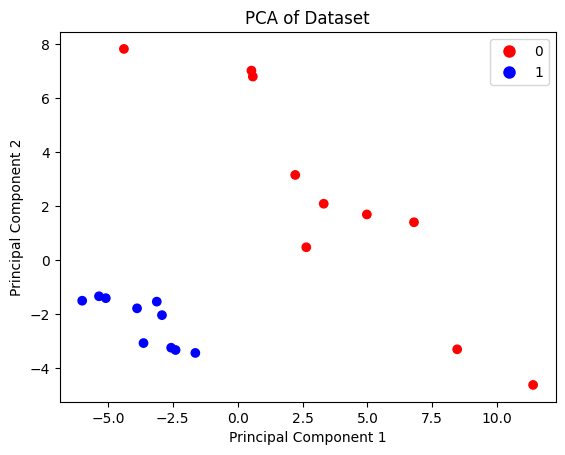

As classes são separáveis linearmente.


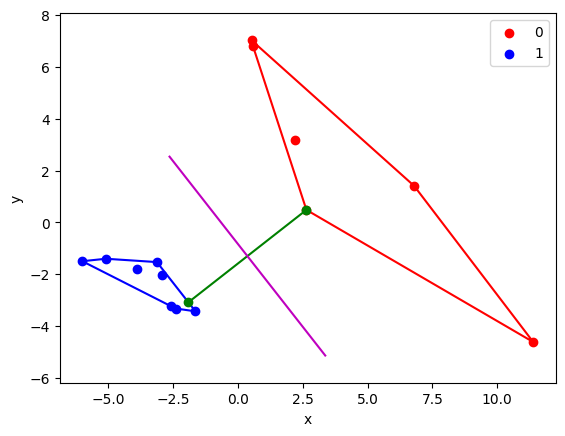

           x         y  target  Predicted Class
0   3.317029  2.094113       0                0
17 -3.627637 -3.059811       1                1
15 -5.342389 -1.328429       1                1
1  -4.382306  7.819885       0                0
8   4.979142  1.697147       0                0
Model Metrics:

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------

Metrics of Class: 0

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------

Metrics of Class: 1

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------


In [165]:
class_column = 'target'
labels = [0, 1]

test_dataset(class_column, labels, faces_df, 3)

# Digits

In [166]:
from sklearn.datasets import load_digits

digits = load_digits()
df = pd.DataFrame(digits.data)
df['target'] = digits.target
df.describe()


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,target
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496,4.490818
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122,2.865304
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000,2.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000,4.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000,7.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,9.000000


Classes: [0, 1]


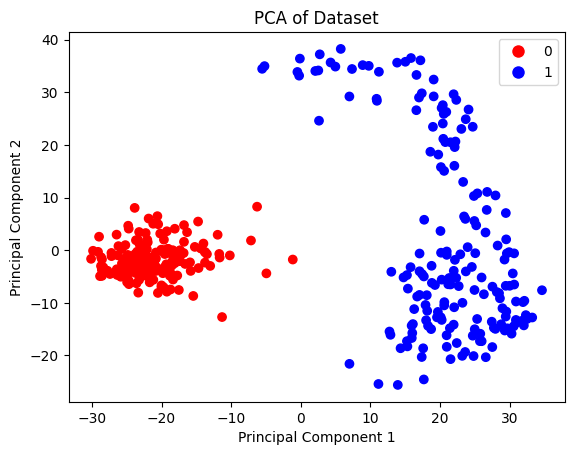

As classes são separáveis linearmente.


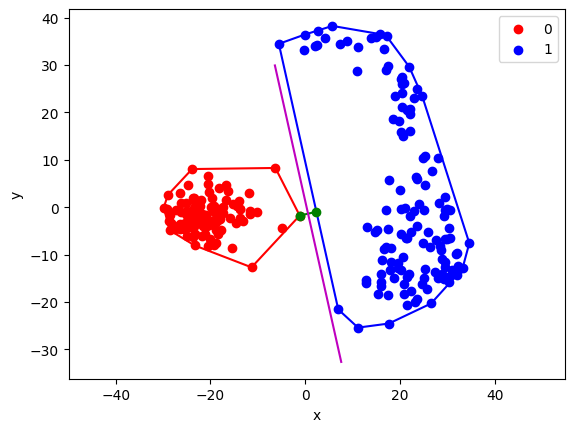

             x          y  target  Predicted Class
224  30.930202  -9.747099       1                1
42  -13.474418  -0.734843       0                0
285 -21.181781  -2.441898       0                0
302   6.994090  29.222559       1                1
56  -20.886410  -3.000853       0                0
Model Metrics:

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------

Metrics of Class: 0

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------

Metrics of Class: 1

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------


In [167]:
class_column = 'target'
labels = [0, 1]

test_dataset(class_column, labels, df, 7)

# Coil 2000

In [168]:
url = "https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/unprocessed/coil2000.csv"
df = pd.read_csv(url)

df.describe()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
count,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,...,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.00000,9822.000000,9822.000000,9822.000000
mean,24.253207,1.108735,2.677561,2.996437,5.779067,0.700672,4.637650,1.050092,3.262981,6.188964,...,0.004582,0.007941,0.004276,0.574018,0.000916,0.005091,0.03146,0.008450,0.013846,0.059662
std,12.918058,0.412101,0.780701,0.804660,2.874148,1.015107,1.721212,1.011156,1.606287,1.896070,...,0.067535,0.088764,0.071224,0.561255,0.030258,0.077996,0.20907,0.092647,0.117728,0.236872
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,10.000000,1.000000,2.000000,2.000000,3.000000,0.000000,4.000000,0.000000,2.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,30.000000,1.000000,3.000000,3.000000,7.000000,0.000000,5.000000,1.000000,3.000000,6.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,35.000000,1.000000,3.000000,3.000000,8.000000,1.000000,6.000000,2.000000,4.000000,7.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,41.000000,10.000000,6.000000,6.000000,10.000000,9.000000,9.000000,5.000000,9.000000,9.000000,...,1.000000,1.000000,2.000000,7.000000,1.000000,2.000000,4.00000,2.000000,2.000000,1.000000


Classes: [1, 18]


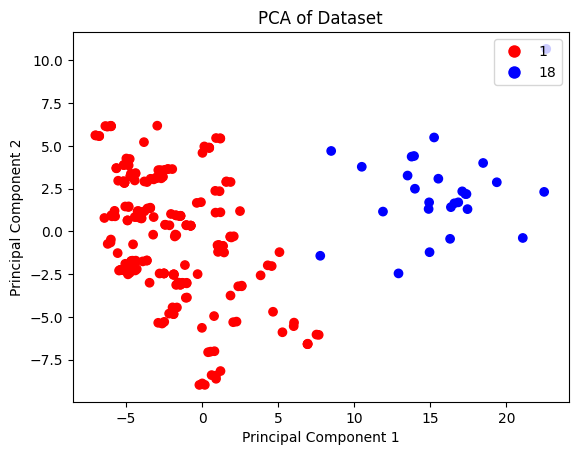

As classes são separáveis linearmente.


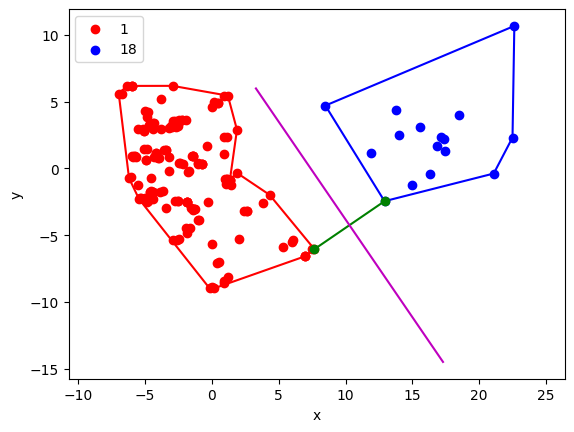

             x         y  MOSTYPE  Predicted Class
24   13.936750  4.404201       18               18
6     1.374511 -0.843027        1                1
153   1.195845  5.421415        1                1
212  -5.849486  0.915841        1                1
199  -4.842066  1.425125        1                1
Model Metrics:

Precision: 0.9922
Recall: 0.9545
F1-Score: 0.9723

------------------------------

Metrics of Class: 1

Precision: 0.9844
Recall: 1.0000
F1-Score: 0.9921

------------------------------

Metrics of Class: 18

Precision: 1.0000
Recall: 0.9091
F1-Score: 0.9524

------------------------------


In [169]:
class_column = 'MOSTYPE'

labels = [1, 18]

test_dataset(class_column, labels, df, 7)

# Dermatology

In [170]:
url = "https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/unprocessed/dermatology.csv"
df = pd.read_csv(url)

df.describe()

,Erythema,Scaling,Definite_borders,Itching,Koebner_phenomenon,Polygonal_papules,Follicular_papules,Oral_mucosal,Knee_and_elbow,Scalp_involvement,...,Granular_layer,Vacuolisation,Spongiosis,Saw-tooth_appearance,Follicular_horn_plug,Perifollicular_parakeratosis,Inflammatory_monoluclear,Band-like_infiltrate,Age,Class
count,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,...,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000
mean,2.078212,1.807263,1.569832,1.354749,0.636872,0.449721,0.170391,0.379888,0.622905,0.530726,...,0.474860,0.460894,0.949721,0.458101,0.106145,0.117318,1.877095,0.558659,36.296089,2.782123
std,0.664865,0.701541,0.900909,1.135062,0.908709,0.956468,0.576394,0.837388,0.990278,0.912352,...,0.871705,0.959914,1.129060,0.959796,0.455180,0.493863,0.699324,1.107990,15.324557,1.593936
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,25.000000,1.000000
50%,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,35.000000,3.000000
75%,2.750000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,49.750000,4.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,75.000000,6.000000


Classes: [1, 4]


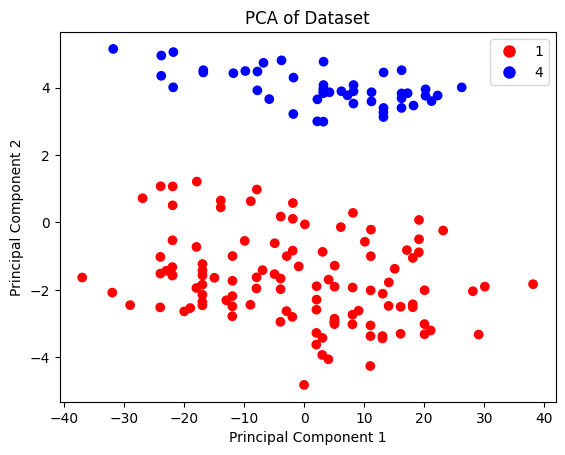

As classes são separáveis linearmente.


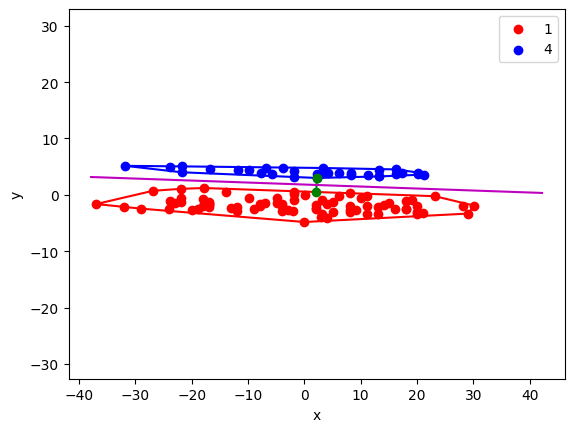

             x         y  Class  Predicted Class
78  -11.925438 -2.486317      1                1
155  14.081102 -2.473858      1                1
128 -11.894205 -0.995579      1                1
55   -7.844592  0.978106      1                1
94   11.031648 -4.254947      1                1
Model Metrics:

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------

Metrics of Class: 1

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------

Metrics of Class: 4

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------


In [171]:
class_column = 'Class'

labels = [1, 4]

test_dataset(class_column, labels, df, 40)

# Glass

In [172]:
url = "https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/unprocessed/glass.csv"
df = pd.read_csv(url)

df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,TypeGlass
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518366,13.413409,2.684516,1.444895,72.655649,0.497235,8.960538,0.177563,0.042611,2.780374
std,0.003037,0.819794,1.442342,0.499361,0.778654,0.652188,1.426621,0.497925,0.092474,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516526,12.906213,2.113668,1.188800,72.279600,0.121095,8.238360,0.000000,0.000000,1.000000
50%,1.517688,13.303550,3.479750,1.358930,72.789200,0.555795,8.604200,0.000000,0.000000,2.000000
75%,1.519163,13.823913,3.600980,1.628570,73.097200,0.608580,9.177170,0.000000,0.056100,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


Classes: [1, 5]


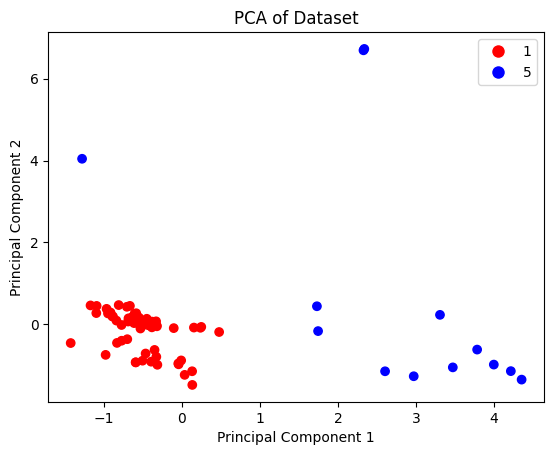

As classes são separáveis linearmente.


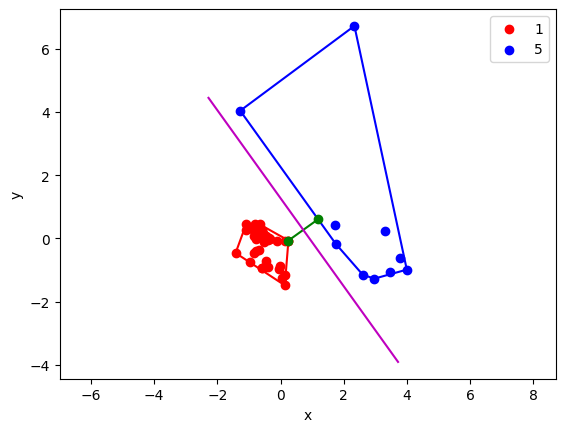

           x         y  TypeGlass  Predicted Class
30 -0.040741 -0.979268          1                1
0  -0.703388  0.426293          1                1
22 -0.383356 -0.076412          1                1
31 -0.881667  0.189720          1                1
18 -0.963250  0.376049          1                1
Model Metrics:

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------

Metrics of Class: 1

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------

Metrics of Class: 5

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------


In [173]:
class_column = 'TypeGlass'

labels = [1, 5]

test_dataset(class_column, labels, df, 3)

# Letter

In [174]:
url = "https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/unprocessed/letter.csv"
df = pd.read_csv(url)

df['Class'].unique()

array(['Z', 'P', 'S', 'H', 'F', 'N', 'R', 'M', 'D', 'V', 'A', 'K', 'E',
       'O', 'Q', 'L', 'X', 'Y', 'I', 'W', 'U', 'T', 'C', 'G', 'B', 'J'],
      dtype=object)

Classes: ['M', 'Z']


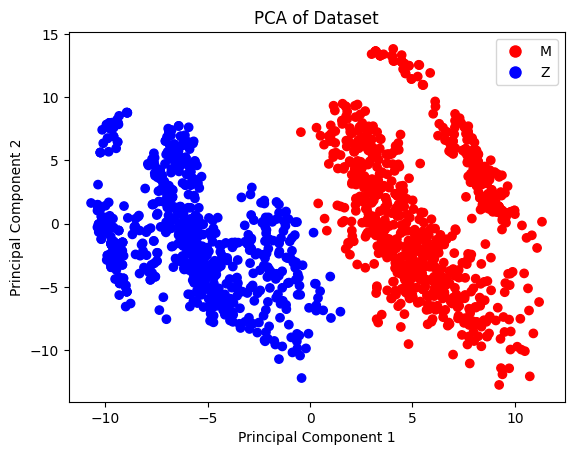

As classes são separáveis linearmente.


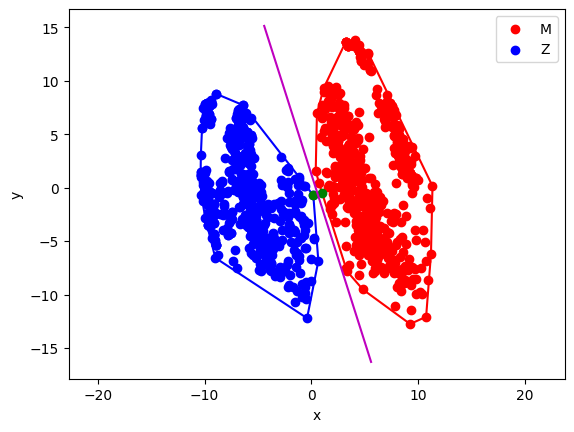

              x         y Class Predicted Class
1439   6.570170 -5.792353     M               M
76     4.461191 -0.107129     M               M
1010 -10.163170  0.209434     Z               Z
660   -5.286863 -2.110333     Z               Z
1132   5.878584 -3.260748     M               M
Model Metrics:

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------

Metrics of Class: M

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------

Metrics of Class: Z

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------


In [175]:
class_column = 'Class'

labels = ['M', 'Z']

test_dataset(class_column, labels, df, 5)

# Movement Libras


In [176]:
url = "https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/unprocessed/movement_libras.csv"
df = pd.read_csv(url)

df['Class'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int64)

Classes: [1, 13]


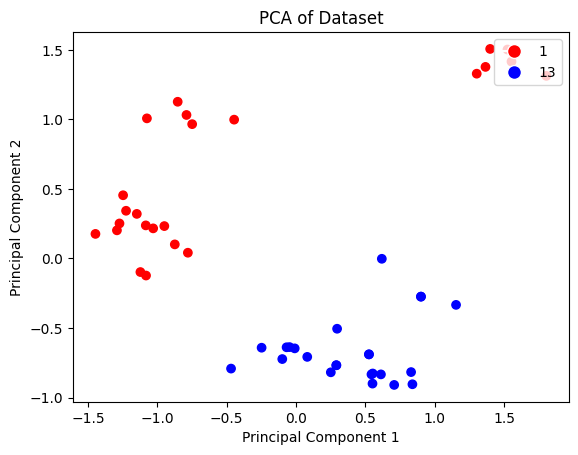

As classes são separáveis linearmente.


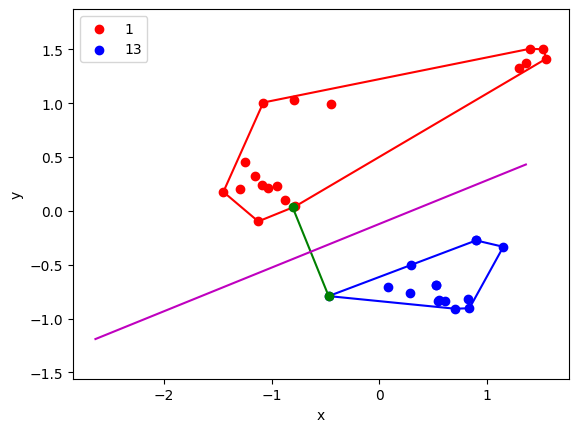

           x         y  Class  Predicted Class
27  0.618599 -0.002299     13               13
40 -0.009883 -0.646248     13               13
26  0.250657 -0.818309     13               13
43  0.290450 -0.767464     13               13
24 -0.099590 -0.723076     13               13
Model Metrics:

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------

Metrics of Class: 1

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------

Metrics of Class: 13

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

------------------------------


In [177]:
class_column = 'Class'

labels = [1, 13]

test_dataset(class_column, labels, df, 2)